In [1]:
import stim
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
# import sinter
from mec import make_circle
from typing import List
# import pymatching
import galois
# from ldpc import bp_decoder, bposd_decoder
# from tqdm import tqdm
from collections import Counter

In [2]:
def lr_bell_pair(paths, p):  # THIS FUNCTION IS WRONG FOR ODD PATH LENGTHS, doesn't matter. Only even
    c = stim.Circuit()

    for path in paths:
        size = len(path)
        c.append("H", path[:-1][::2])
        c.append("DEPOLARIZE1", path[:-1][(size%2)::2], p/10)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[:size-(size%2)])
        c.append("DEPOLARIZE2", path[:size-(size%2)], p)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[1:size-1+(size%2)])
        c.append("DEPOLARIZE2", path[1:size-1+(size%2)], p)
    c.append("TICK")

    for path in paths:
        c.append("H", path[:-1][1::2])
        c.append("DEPOLARIZE1", path[:-1][2::2], p/10)
    c.append("TICK")

    for path in paths:
        c.append("X_ERROR", path[1:-1], p)
        c.append("MR", path[1:-1])
        c.append("X_ERROR", path[1:-1], p/10)
    c.append("TICK")

    for j, path in enumerate(paths):
        tot_len = sum([len(p[1:-1]) for p in paths[j:]])
        size = len(path)
        for i in range(1 + (size%2), size-1, 2):
            c.append("CZ", [stim.target_rec(-tot_len+i-1), path[0]])
        c.append("DEPOLARIZE1", path[0], p/10)
        for i in range(2 - (size%2), size-1, 2):
            c.append("CX", [stim.target_rec(-tot_len+i-1), path[-1]])
        c.append("DEPOLARIZE1", path[-1], p/10)
    c.append("TICK")

    return c

def lr_CNOT_bell(paths, p):
    c = stim.Circuit()

    for path in paths:
        c.append("CNOT", [path[0], path[2][0], path[2][1], path[1]])
        c.append("DEPOLARIZE2", [path[0], path[2][0], path[2][1], path[1]], p)
    c.append("TICK")

    for path in paths:
        c.append("X_ERROR", [path[2][0], path[2][1]], p)
        c.append("MR", path[2][0])
        c.append("MRX", path[2][1])
        c.append("X_ERROR", [path[2][0], path[2][1]], p/10)
    c.append("TICK")

    for j, path in enumerate(paths[::-1]):
        c.append("CX", [stim.target_rec(-2*j-2), path[1]])
        c.append("CZ", [stim.target_rec(-2*j-1), path[0]])
        c.append("DEPOLARIZE1", [path[0], path[1]], p/10)
    c.append("TICK")
    return c

def lr_CNOT_no_bell(paths):
    # path[0] is control, path[-1] is target. Reverse path to get reverse CNOT
    c = stim.Circuit()

    for path in paths:
        size = len(path)
        c.append("H", path[:-1][2::2])
        c.append("DEPOLARIZE1", path[:-1][2::2], 0.001)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[:size-(size%2)])
        c.append("DEPOLARIZE2", path[:size-(size%2)], 0.001)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[1:size-1+(size%2)])
        c.append("DEPOLARIZE2", path[1:size-1+(size%2)], 0.001)
    c.append("TICK")

    for path in paths:
        c.append("H", path[:-1][1::2])
        c.append("DEPOLARIZE1", path[:-1][2::2], 0.001)
    c.append("TICK")

    for path in paths:
        c.append("X_ERROR", path[1:-1], 0.001)
        c.append("MR", path[1:-1])
        c.append("X_ERROR", path[1:-1], 0.001)
    c.append("TICK")

    for j, path in enumerate(paths):
        tot_len = sum([len(p[1:-1]) for p in paths[j:]])
        size = len(path)
        for i in range(1 + (size%2), size-1, 2):
            c.append("CZ", [stim.target_rec(-tot_len+i-1), path[0]])
        c.append("DEPOLARIZE1", path[0], 0.001)
        for i in range(2 - (size%2), size-1, 2):
            c.append("CX", [stim.target_rec(-tot_len+i-1), path[-1]])
        c.append("DEPOLARIZE1", path[-1], 0.001)
    c.append("TICK")

    return c, sum([len(p[1:-1]) for p in paths])

In [3]:
def test_bell(l, p):
    bell_circuit = lr_bell_pair([np.arange(l)], p)
    bell_circuit2 = lr_bell_pair([[i+l for i in np.arange(l)]], p)
    # bell_circuit3 = lr_bell_pair([[i+2*l for i in np.arange(l)]], p)

    control = 100
    target = 101

    c_0 = 0
    c_1 = 0
    c_01 = 0
    c_11 = 0

    num_iters = 1
    for i in range(num_iters):
        s = stim.TableauSimulator()
        s.do(bell_circuit)
        s.do(bell_circuit2)
        # s.do(bell_circuit3)


        # s.do(stim.Circuit(
        # f"""
        # # SQRT_X {2*l} {3*l-1}
        # CX {2*l} 0 {3*l-1} {l-1}
        # # DEPOLARIZE2(0.001) {2*l} 0 {3*l-1} {l-1}
        # H {2*l} {3*l-1}
        # # X 0
        # M {2*l} {3*l-1}
        # """
        # ))
        # res = s.current_measurement_record()
        # if res[-1] != res[-2]: continue


        s.do(stim.Circuit(
        f"""
        CX 0 {l} {l-1} {2*l-1}
        DEPOLARIZE2({p}) 0 {l} {l-1} {2*l-1}
        X_ERROR({p}) {l} {2*l-1}
        MR {l} {2*l-1}
        """
        ))
        res = s.current_measurement_record()

        if res[-1] != res[-2]:
            c_0 += 1

            # if (np.random.random() < 0.5): s.x(control)
            s.h(control)
            s.do(lr_CNOT_bell([[control, target, (0, l-1)]], p))
            res = s.measure_many(control, target)
            # res = s.measure_many(0, l-1)

            if res[0] != res[1]: c_01 += 1
        else:
            c_1 += 1

            # if (np.random.random() < 0.5): s.x(control)
            s.h(control)
            s.do(lr_CNOT_bell([[control, target, (0, l-1)]], p))
            res = s.measure_many(control, target)
            # res = s.measure_many(0, l-1)

            if res[0] != res[1]: c_11 += 1
    # res = (l, c_01/c_0, c_11/c_1, c_1/num_iters)

    s.current_inverse_tableau.to_circuit()
    # print(res)
    # return res

arr = [test_bell(i, 0.001) for i in range(52,82,2)]

AttributeError: 'builtin_function_or_method' object has no attribute 'to_circuit'

In [35]:
# arr = [(4, 0.49577464788732395, 0.004295749734674281, 0.98935),
#  (6, 0.5016077170418006, 0.0037279699324495913, 0.98445),
#  (8, 0.5072815533980582, 0.003726771492750664, 0.9794),
#  (10, 0.49300155520995337, 0.003890052141068276, 0.97428),
#  (12, 0.5042428198433421, 0.003992324832879425, 0.96936),
#  (14, 0.502093217973765, 0.0040656730659530994, 0.96417),
#  (16, 0.517198404785643, 0.00450056257032129, 0.95988),
#  (18, 0.4924645390070922, 0.004346095844504022, 0.95488),
#  (20, 0.4986528098537336, 0.004177038943504493, 0.94804),
#  (22, 0.5050993022007515, 0.004671065871561577, 0.94411),
#  (24, 0.49563642351391407, 0.004578023358565695, 0.93927),
#  (26, 0.4938013442867812, 0.004629976957290606, 0.93305),
#  (28, 0.4945722970039079, 0.005650385107045794, 0.93091),
#  (30, 0.4895625581704561, 0.005276873668616659, 0.92479),
#  (32, 0.4973828673560577, 0.00639057363264509, 0.92167),
#  (34, 0.4972806810120596, 0.005625832950995171, 0.91542),
#  (36, 0.5002244165170556, 0.00625768487616371, 0.91088),
#  (38, 0.5004819535182606, 0.007301765880237804, 0.90663),
#  (40, 0.5038402457757296, 0.006793372859755084, 0.90235),
#  (42, 0.49624654286843145, 0.007343450976901509, 0.89876),
#  (44, 0.49911668991166896, 0.00719368031822511, 0.89245),
#  (46, 0.5071866703286643, 0.007858369725069323, 0.89077),
#  (48, 0.5073355003074761, 0.00845210286965255, 0.88617),
#  (50, 0.5022462562396006, 0.008092748351898158, 0.8798),
#  (52, 0.4957387495021904, 0.009949110869689519, 0.87445),
# (54, 0.49844913151364767, 0.010619489346069067, 0.87104),
# (56, 0.49262270400481784, 0.009640666082383873, 0.86716),
# (58, 0.4928065598210958, 0.011526245885545995, 0.86585),
# (60, 0.4897009029345372, 0.011232289336316183, 0.85824),
# (62, 0.4945220487537661, 0.012389339079113776, 0.85396),
# (64, 0.49299644795925207, 0.012306209522913997, 0.85079),
# (66, 0.4880866897317057, 0.013332388611376814, 0.84681),
# (68, 0.4954752583274501, 0.013930513273078336, 0.84419),
# (70, 0.4862287470983123, 0.013335553942969987, 0.84061),
# (72, 0.48929421094369546, 0.014568158168574402, 0.83607),
# (74, 0.494243223794675, 0.015265709759493063, 0.83324),
# (76, 0.493810580404064, 0.015891594468711537, 0.82874),
# (78, 0.5016461618437013, 0.015758220760216237, 0.82687),
# (80, 0.4959785522788204, 0.017442993568505163, 0.82096)]

In [42]:
muls001 = np.zeros(81)
for a in arr:
    muls001[a[0]] = a[2] / 0.001
    # muls001[a[0]] = a[3]

muls001

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 5.75421291, 0.        , 6.06743327,
       0.        , 6.63790984, 0.        , 6.33608196, 0.        ,
       7.24417597, 0.        , 6.69331914, 0.        , 7.44078094,
       0.        , 7.59173345, 0.        , 8.37524776, 0.        ,
       8.38899217, 0.        , 8.80930114, 0.        , 9.80709

Text(0, 0.5, 'Effective CNOT error rate')

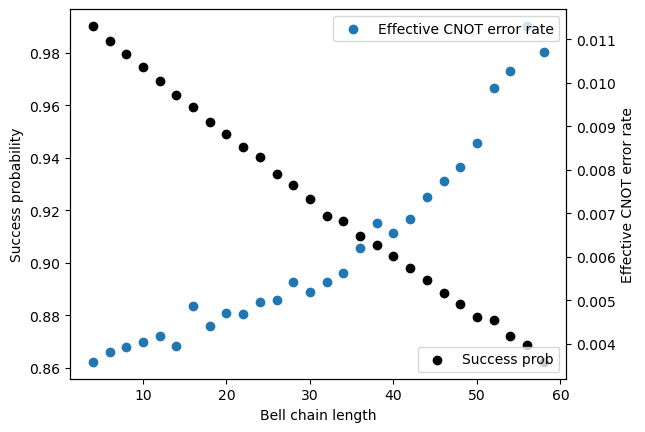

In [41]:
fig, ax1 = plt.subplots()

ax1.scatter(np.array(arr)[:,0], np.array(arr)[:,2], c='k', label="Success prob")

ax2 = ax1.twinx()
ax2.scatter(np.array(arr)[:,0], np.array(arr)[:,1], label="Effective CNOT error rate")
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

ax1.set_xlabel("Bell chain length")
ax1.set_ylabel("Success probability")
ax2.set_ylabel("Effective CNOT error rate")


In [38]:
rx = 1/np.sqrt(2)*np.array([
    [1,-1j],
    [-1j,1]
])
rx_dag = 1/np.sqrt(2)*np.array([
    [1,1j],
    [1j,1]
])
sqrtx = 1/2*np.array([
    [1+1j,1-1j],
    [1-1j, 1+1j]
])
print(sqrtx)

[[0.5+0.5j 0.5-0.5j]
 [0.5-0.5j 0.5+0.5j]]


In [33]:
H = 1/np.sqrt(2)*np.array([
    [1,1],
    [1,-1]
])
S = np.array([
    [1,0],
    [0,np.exp(1j*np.pi/2)]
])
S_dag = np.array([
    [1,0],
    [0,-1j]
])

theta = np.pi/2
Rx = np.array([
    [np.cos(theta/2), -1j*np.sin(theta/2)],
    [-1j*np.sin(theta/2), np.cos(theta/2)]
])

print(Rx)
print(S@H)

[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
[[ 7.07106781e-01+0.j          7.07106781e-01+0.j        ]
 [ 4.32978028e-17+0.70710678j -4.32978028e-17-0.70710678j]]


In [ ]:
# 4 0.0015451111874128982 0.99022
# 6 0.0013810611830413811 0.98475
# 0.0016733051369441137 0.97412

    # H 0 {l-1} {l} {2*l-1}
    # S 0 {l}
    # S_DAG {l-1} {2*l-1}

In [525]:
code = [12,3,9,1,2,0,7,2,3,12,2,1]

def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)

GF = galois.GF(2)
arr = GF(Hz.T)
k = 2 * (Hz.T.shape[1] - matrix_rank(arr))

def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

lattice = embed_code((code[8],code[9],code[10],code[11]), 0)

all_qbts = {}

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            all_qbts[(i,j)] = int(lattice[i][j][1:])
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)

x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

lr_x_checks = np.array([], dtype=int)
sr_x_checks = np.array([], dtype=int)
lr_z_checks = np.array([], dtype=int)
sr_z_checks = np.array([], dtype=int)

for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        lr_x_checks = np.append(lr_x_checks, i)
    else:
        sr_x_checks = np.append(sr_x_checks, i)

for i, z_check in enumerate(z_checks):
    gen_qbts = qbts[np.where(Hz[i])[0]]

    nonlocal_qbts = []
    if (z_rs[i] > min(z_rs)+np.std(z_rs)):
        lr_z_checks = np.append(lr_z_checks, i)
    else:
        sr_z_checks = np.append(sr_z_checks, i)

In [626]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))

def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break

        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)

    return (logicals, generators)

def get_logicals(gen_type=False):
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])

    if gen_type: return logX
    else: return logZ

def observables(type):
    c = stim.Circuit()
    for i, logical in enumerate(get_logicals(type)):
        incl_qbts = np.where(logical)[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)
    return c

In [1017]:
def direct_CNOT(paths):
    c = stim.Circuit()
    qbt_paths = []
    for path in paths:
        qbt_paths += [all_qbts[path[0]], all_qbts[path[-1]]]
    c.append("CNOT", qbt_paths)
    c.append("DEPOLARIZE2", qbt_paths, 0.001)
    c.append("TICK")
    return c

def sr_z_down_right(checks, gen_index, mod, col_ind=[1,2]):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]), (z_checks[z][0]-3, z_checks[z][1]+6)] for z in z_checks_i]
    return z_paths

def sr_z_down_left(checks, gen_index, mod, col_ind=[0]):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]), (z_checks[z][0]+3, z_checks[z][1]+6)] for z in z_checks_i]
    return z_paths

def sr_z_down(checks, gen_index, mod, col_ind):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[all_qbts[(z_checks[z][0], z_checks[z][1]+i)]+4*m*ell for i in range(4)] for z in z_checks_i]
    pur_paths = [[all_qbts[(z_checks[z][0]-1, z_checks[z][1]+i)]+4*m*ell for i in range(4)] for z in z_checks_i]
    return z_checks_i, z_paths, pur_paths

def z_right_bdy(checks, gen_index, mod, col_ind=[2]):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[all_qbts[(z_checks[z][0]-i, z_checks[z][1])]+4*m*ell for i in range(6)] for z in z_checks_i]
    pur_paths = [[all_qbts[(z_checks[z][0]-i, z_checks[z][1]-1)]+4*m*ell for i in range(6)] for z in z_checks_i]
    return z_checks_i, z_paths, pur_paths

def z_down_local(checks, gen_index, mod, col_ind):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]+i) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths

def z_left_local(checks, gen_index, mod, col_ind):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths

def z_up_local(checks, gen_index, mod, col_ind):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]-i) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths

def z_right_local(checks, gen_index, mod, col_ind):
    z_checks_i = [z for z in checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 in col_ind)]
    z_paths = [[(z_checks[z][0]+i, z_checks[z][1]) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths

In [1015]:
def manhattan(qbts):
    p, q = qbts
    return np.abs(p[0]-q[0])+np.abs(p[1]-q[1])

def measure_x_checks(checks, scale=False):
    c = stim.Circuit()
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], 0.001)
    for x in checks:
        gen_qbts = qbts[np.where(Hx[x])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[x_checks[x]], all_qbts[qbt]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, 0.001*manhattan([x_checks[x], qbt])/2)
            else:
                c.append("DEPOLARIZE2", path_qbts, 0.001)
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], 0.001)
    return c

def measure_z_checks(checks, scale=False):
    c = stim.Circuit()
    for z in checks:
        gen_qbts = qbts[np.where(Hz[z])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[qbt], all_qbts[z_checks[z]]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, 0.001*manhattan([qbt, z_checks[z]])/2)
            else:
                c.append("DEPOLARIZE2", path_qbts, 0.001)
    return c

def all_checks():
    c = stim.Circuit()
    c += measure_z_checks(sr_z_checks, True)
    c += measure_z_checks(lr_z_checks, False)
    # c += measure_x_checks(sr_x_checks, True)
    # c += measure_x_checks(lr_x_checks, False)
    return c

In [886]:
def purify(bell, donor):
    c = stim.Circuit()
    for b, d in zip(bell, donor):
        c.append("CNOT", [b[0], d[0], b[-1], d[-1]])
    c.append("TICK")
    for d in donor:
        c.append("M", [d[0], d[-1]])
    c.append("TICK")
    return c

s = stim.TableauSimulator()
c = stim.Circuit()

prev_meas_z = np.arange(1, m*ell+1, dtype=int)
curr_meas_z = np.zeros(m*ell, dtype=int)
# prev_x_meas = np.arange(m*ell+1, 2*m*ell+1)

for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
    c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
c.append("R", [qbt for qbt in all_qbts.values()])
c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
c.append("TICK")

c += all_checks().without_noise()
c.append("MR", [all_qbts[z_check] for z_check in z_checks])
s.do(c)


# reset this every round
route_confirmation_z = np.ones(m*ell)
route_confirmation_z[lr_z_checks] = -1  # change this on long range rounds


z_checks_i, b, d = sr_z_down(sr_z_checks[route_confirmation_z[sr_z_checks]==1], 0, 2, [0,1,2])
c += lr_bell_pair(b, 0.001)
s.do(lr_bell_pair(b, 0.001))
c += purify(b,d)
s.do(purify(b,d))

for i, z in enumerate(z_checks_i):
    if s.current_measurement_record()[-2*i-1] != s.current_measurement_record()[-2*i-2]:
        route_confirmation_z[z] = 0
c += lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (d[i][0], d[i][-1])] for i, z in enumerate(z_checks_i) if route_confirmation_z[z]])
s.do(lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (d[i][0], d[i][-1])] for i, z in enumerate(z_checks_i) if route_confirmation_z[z]]))

# z_checks_i, b, d = sr_z_down(sr_z_checks[route_confirmation_z[sr_z_checks]==1], 1, 2, [0,1,2])
# c += lr_bell_pair(b+d, 0.001)
# s.do(lr_bell_pair(b+d, 0.001))
# c += purify(b,d)
# s.do(purify(b,d))

# for i, z in enumerate(z_checks_i):
#     if s.current_measurement_record()[-2*i-1] != s.current_measurement_record()[-2*i-2]:
#         route_confirmation_z[z] = 0
# c += lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (d[i][0], d[i][-1])] for i, z in enumerate(z_checks_i)])


# z_checks_i, b, d = z_right_bdy(sr_z_checks[route_confirmation_z[sr_z_checks]==1], 0, 1)
# c += lr_bell_pair(b+d, 0.001)
# s.do(lr_bell_pair(b+d, 0.001))
# c += purify(b,d)
# s.do(purify(b,d))

# for i, z in enumerate(z_checks_i):
#     if s.current_measurement_record()[-2*i-1] != s.current_measurement_record()[-2*i-2]:
#         route_confirmation_z[z] = 0
# c += lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (d[i][0], d[i][-1])] for i, z in enumerate(z_checks_i) if route_confirmation_z[z]])

# c += direct_CNOT(z_down_local(sr_z_checks, 0,1,[0,1,2]))
# c += direct_CNOT(z_left_local(sr_z_checks, 0,1,[0,1,2]))
# c += direct_CNOT(z_right_local(sr_z_checks, 0,1,[0,1]))
# c += direct_CNOT(z_up_local(sr_z_checks, 0,1,[0,1,2]))
# c += direct_CNOT(sr_z_down_right(sr_z_checks, 0, 1))

for i, z in enumerate(route_confirmation_z):
    if z == 1:
        c.append("M", all_qbts[z_checks[i]])
        s.measure(all_qbts[z_checks[i]])
        curr_meas_z[i] = c.num_measurements
# c.append("R", np.array([all_qbts[z] for z in z_checks])[route_confirmation_z==0])

c2 = stim.Circuit()
num_meas = c.num_measurements
for i, z in enumerate(route_confirmation_z):
    if z == 1:
        coord = z_checks[i]
        c2.append("DETECTOR", [stim.target_rec(curr_meas_z[i]-num_meas-1), stim.target_rec(prev_meas_z[i]-num_meas-1)], (coord[0], coord[1], 0))
c += c2
s.do(c2)


print(route_confirmation_z)

# with open("tmp.svg", "w") as f:
#     f.write(str(c.without_noise().diagram("timeslice-svg")))

[ 1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.]


In [887]:
print(prev_meas_z)
print(curr_meas_z)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
[127 128 129 130 131 132   0   0   0 133 134 135 136 137 138 139 140 141 142 143 144   0   0   0 145 146 147   0   0   0 148 149 150 151 152 153]


In [888]:
shot = s.current_measurement_record()
shot = np.array([shot], dtype=np.bool_)
print(len(shot[0]))

153


In [889]:
converter = c.compile_m2d_converter()
dets = converter.convert(measurements=shot, separate_observables=False)
dets

array([[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]])

In [890]:
c.detector_error_model()

stim.DetectorErrorModel('''
    error(0.000533333) D0
    error(0.000533333) D1
    error(0.000533333) D2
    error(0.000533333) D9
    error(0.000533333) D10
    error(0.000533333) D11
    error(0.000533333) D15
    error(0.000533333) D16
    error(0.000533333) D17
    error(0.000533333) D18
    error(0.000533333) D19
    error(0.000533333) D20
    error(0.000533333) D21
    error(0.000533333) D22
    error(0.000533333) D23
    detector(3, 1, 0) D0
    detector(5, 1, 0) D1
    detector(1, 1, 0) D2
    detector(3, 11, 0) D3
    detector(5, 11, 0) D4
    detector(1, 11, 0) D5
    detector(3, 7, 0) D6
    detector(5, 7, 0) D7
    detector(1, 7, 0) D8
    detector(3, 17, 0) D9
    detector(5, 17, 0) D10
    detector(1, 17, 0) D11
    detector(3, 3, 0) D12
    detector(5, 3, 0) D13
    detector(1, 3, 0) D14
    detector(3, 13, 0) D15
    detector(5, 13, 0) D16
    detector(1, 13, 0) D17
    detector(3, 9, 0) D18
    detector(5, 9, 0) D19
    detector(1, 9, 0) D20
    detector(3, 5, 0) D21


In [1018]:
num_rounds = 10
lr_time = 100

prev_meas_z = np.arange(1, m*ell+1, dtype=int)
curr_meas_z = np.zeros(m*ell, dtype=int)
# prev_x_meas = np.arange(m*ell+1, 2*m*ell+1)

c = stim.Circuit()
for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
    # c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
c.append("R", [qbt for qbt in all_qbts.values()])
# c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
c.append("TICK")

c += all_checks().without_noise()
c.append("MR", [all_qbts[z_check] for z_check in z_checks])
c.append("TICK")

# reset this every round

for i in range(num_rounds):
    c.append("SHIFT_COORDS", [], (0,0,1))

    route_confirmation_z = np.ones(m*ell)
    route_confirmation_z[lr_z_checks] = 0  # change this on long range rounds

    z_checks_i, b, d = sr_z_down(sr_z_checks[route_confirmation_z[sr_z_checks]==1], 0, 2, [0,1,2])
    qbt_paths = []
    for path in b:
        qbt_paths += [path[0], path[-1]]
    c.append("CNOT", qbt_paths)
    c.append("DEPOLARIZE2", qbt_paths, 0.001)
    # c += lr_bell_pair(b, 0.001)
    # c += lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (b[i][0], b[i][-1])] for i, z in enumerate(z_checks_i) if route_confirmation_z[z]==1], 0.001)
    # c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])

    z_checks_i, b, d = sr_z_down(sr_z_checks[route_confirmation_z[sr_z_checks]==1], 1, 2, [0,1,2])
    qbt_paths = []
    for path in b:
        qbt_paths += [path[0], path[-1]]
    c.append("CNOT", qbt_paths)
    c.append("DEPOLARIZE2", qbt_paths, 0.001)
    # c += lr_bell_pair(b, 0.001)
    # c += lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (b[i][0], b[i][-1])] for i, z in enumerate(z_checks_i) if route_confirmation_z[z]==1], 0.001)
    # c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])

    z_checks_i, b, d = z_right_bdy(sr_z_checks[route_confirmation_z[sr_z_checks]==1], 0, 1)
    qbt_paths = []
    for path in b:
        qbt_paths += [path[0], path[-1]]
    c.append("CNOT", qbt_paths)
    c.append("DEPOLARIZE2", qbt_paths, 0.001)
    # c += lr_bell_pair(b, 0.001)
    # c += lr_CNOT_bell([[b[i][0]-4*m*ell, b[i][-1]-4*m*ell, (b[i][0], b[i][-1])] for i, z in enumerate(z_checks_i) if route_confirmation_z[z]==1], 0.001)
    # c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])


    c += direct_CNOT(z_down_local(sr_z_checks, 0,1,[0,1,2]))
    c += direct_CNOT(z_left_local(sr_z_checks, 0,1,[0,1,2]))
    c += direct_CNOT(z_right_local(sr_z_checks, 0,1,[0,1]))
    c += direct_CNOT(z_up_local(sr_z_checks, 0,1,[0,1,2]))
    c += direct_CNOT(sr_z_down_right(sr_z_checks, 0,1))
    c += direct_CNOT(sr_z_down_left(sr_z_checks, 0,1))

    for i, z in enumerate(route_confirmation_z):
        if z == 1:
            c.append("M", all_qbts[z_checks[i]])
            curr_meas_z[i] = c.num_measurements
    # c.append("R", np.array([all_qbts[z] for z in z_checks])[route_confirmation_z==0])

    num_meas = c.num_measurements

    print(prev_meas_z)
    print(curr_meas_z)
    print(num_meas)

    for i, z in enumerate(route_confirmation_z):
        if z == 1:
            coord = z_checks[i]
            c.append("DETECTOR", [stim.target_rec(curr_meas_z[i]-num_meas-1), stim.target_rec(prev_meas_z[i]-num_meas-1)], (coord[0], coord[1], 0))
            prev_meas_z[i] = curr_meas_z[i]
            curr_meas_z[i] = 0


# c += all_checks().without_noise()
# curr_meas_z = np.arange(c.num_measurements+1, c.num_measurements+m*ell+1)
# c.append("MR", [all_qbts[z_check] for z_check in z_checks])

# num_meas = c.num_measurements
# for i, z in enumerate(z_checks):
#     coord = z_checks[i]
#     c.append("DETECTOR", [stim.target_rec(curr_meas_z[i]-num_meas-1), stim.target_rec(prev_meas_z[i]-num_meas-1)], (coord[0], coord[1], 0))
#     prev_meas_z[i] = curr_meas_z[i]
#     curr_meas_z[i] = 0
c.append("M",[all_qbts[qbt] for qbt in qbts[::-1]])
c += observables(False)

# with open("tmp.svg", "w") as f:
#     f.write(str(c.without_noise().diagram("timeslice-svg")))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
[37 38 39 40 41 42  0  0  0 43 44 45 46 47 48 49 50 51 52 53 54  0  0  0 55 56 57  0  0  0 58 59 60 61 62 63]
63
[37 38 39 40 41 42  7  8  9 43 44 45 46 47 48 49 50 51 52 53 54 22 23 24 55 56 57 28 29 30 58 59 60 61 62 63]
[64 65 66 67 68 69  0  0  0 70 71 72 73 74 75 76 77 78 79 80 81  0  0  0 82 83 84  0  0  0 85 86 87 88 89 90]
90
[64 65 66 67 68 69  7  8  9 70 71 72 73 74 75 76 77 78 79 80 81 22 23 24 82 83 84 28 29 30 85 86 87 88 89 90]
[ 91  92  93  94  95  96   0   0   0  97  98  99 100 101 102 103 104 105 106 107 108   0   0   0 109 110 111   0   0   0 112 113 114 115 116 117]
117
[ 91  92  93  94  95  96   7   8   9  97  98  99 100 101 102 103 104 105 106 107 108  22  23  24 109 110 111  28  29  30 112 113 114 115 116 117]
[118 119 120 121 122 123   0   0   0 124 125 126 127 128 129 130 131 132 133 134 135   0   0   0 136 137 138   0   0   0 139 140 141 142 143 144]
14

In [1025]:
np.set_printoptions(linewidth=200)
detector_sampler = c.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1, append_observables=True)[0]
print(len(one_sample))

ind = 0
for i in range(1,num_rounds+1):
    if (i%lr_time==0):
        timeslice = one_sample[ind:ind+len(z_checks)]
        ind += len(z_checks)
    else:
        timeslice = one_sample[ind:ind+len(sr_z_checks)]
        ind += len(sr_z_checks)
    print("".join("!" if e else "_" for e in timeslice))

timeslice = one_sample[ind:-k]
print("".join("!" if e else "_" for e in timeslice))
timeslice = one_sample[-k:]
print("".join("!" if e else "_" for e in timeslice))

278
___________________________
_________________!_________
_____!___________!_________
_____!___!!______!_________
_____!___!!______!_________
_____!___________!_________
_____!___________!_________
_____!___!!______!_________
_____!___!!______!_________
_____!___________!_________

_!____!!


In [1026]:
from scipy.sparse import lil_matrix

dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

errors = []
channel_probs = [e.args_copy()[0] for e in c.detector_error_model() if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(270, 1449)
(8, 1449)


In [1027]:
bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="msl",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],10) #the osd search depth
)

In [1028]:
count = 0
num_iters = 1000

sampler = c.compile_detector_sampler()
for i in tqdm(range(num_iters)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    # guessed_errors = bp_dec.decode(detection_events[0])
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2

    if not np.all(observable_flips[0].astype(int) == guessed_obs):
        count += 1
print(count/num_iters)

100%|██████████| 1000/1000 [00:03<00:00, 261.05it/s]

0.11
